In [55]:
from abc import ABC, abstractmethod
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [56]:
lite = yf.Ticker("LITE").history(period="30y")
tsla = yf.Ticker("TSLA").history(period="30y")
aapl = yf.Ticker("AAPL").history(period="30y")

In [308]:
def res(x, df):
    
    """
    Function that takes a moving average pair as a list in the variable x, and a dataframe containing a Close price 
    and returns the final cumulative return that would be earned by applying a simple momentum strategy using that 
    moving average combination. 
    """
    
    x = [int(np.floor(x)) for x in x]

    # calculating MAs
    df["STMA"] = df["Close"].rolling(x[0]).mean()
    df["LTMA"] = df["Close"].rolling(x[1]).mean()

    # initialising signal column and calculating the signal
    df["Signal"] = np.nan
    df.loc[df["LTMA"] < df["STMA"], "Signal"] = 1 # trending up - 1 for momentum 
    df.loc[df["LTMA"] >= df["STMA"], "Signal"] = 0 # trending down - 0 for momentum

    # calculating returns and strategy returns
    df["Returns"] = df["Close"].apply(np.log).diff(1)
    df["Strat_Returns"] = df["Returns"][1:]*df["Signal"]

    # calculating cumulative returns
    df["Strat_Cum_Returns"] = df["Strat_Returns"].cumsum().apply(np.exp)
    df["Cum_Returns"] = df["Returns"].cumsum().apply(np.exp)
    
    # dropping nans from calculating MAs
    df = df.dropna()
    
    return df["Strat_Cum_Returns"][-1]

def random_pair(lb, ub):
    """
    Function that takes a lower (lb) and upper (up) bound and returns a pair of short and long term moving average parameters.
    The function ensures the parameters are not equal and and that the long term ma is greater than the short term ma. 
    """
    st = random.randint(lb, ub)
    lt = random.randint(lb, ub)
    
    if st == lt:
        return random_pair(lb, ub)
    
    elif st > lt:
        tmp = st
        st = lt
        lt = tmp
        return [st, lt]
    
    else:
        return [st, lt]

In [332]:
import random

# importing data
data = aapl
data = data[["Open", "Close"]]
data = data.dropna()

# number of moving average pair simulations
N = 1000

# generating moving average pairs
mas = [random_pair(2, 200) for i in range(N)]

# generating cumulative returns for each pair
cum_rets = [res(mas[i], data) for i in range(N)]  

# appending the results to the moving average pairs
for i in range(N):
    mas[i].append(cum_rets[i])
    
# initialising dataframe of results
result = pd.DataFrame(mas)
result.columns = ["STMA", "LTMA", "Final Cum Ret"]

# maximum cumulative return
result.iloc[result["Final Cum Ret"].argmax(), :]

sorted_result = result.sort_values("Final Cum Ret", ascending=False)

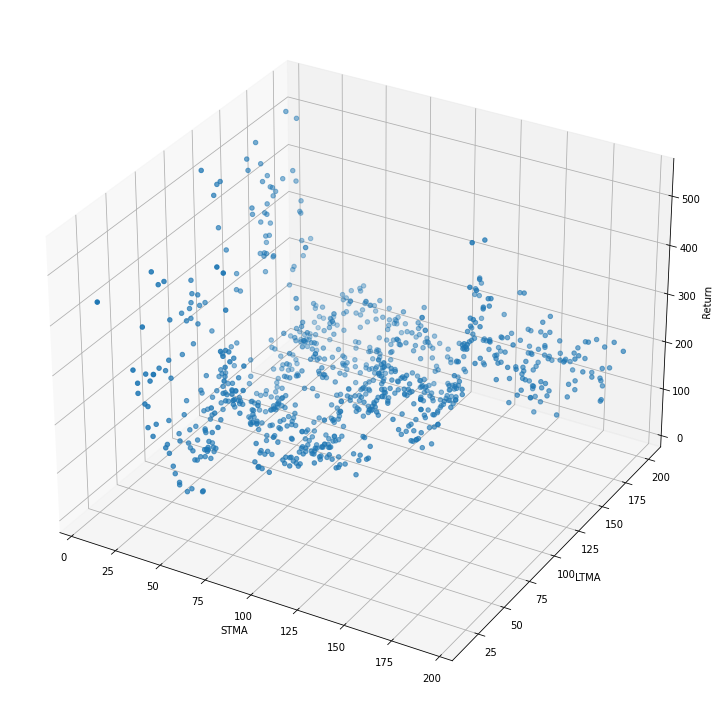

In [333]:
import matplotlib.pyplot as plt
 
xs = sorted_result[100:]["STMA"].values
ys = sorted_result[100:]["LTMA"].values
zs = sorted_result[100:]["Final Cum Ret"].values

fig = plt.figure(figsize=(10,20))
ax = plt.axes(projection ='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('STMA')
ax.set_ylabel('LTMA')
ax.set_zlabel('Return',)
plt.tight_layout()
plt.show()